In [3]:
#importing libraries
import numpy as np
import cv2
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

import pickle
import tkinter as tk
from tkinter import filedialog
from tkinter import PhotoImage
from pygame import mixer
import matplotlib.pyplot as plt
import random

In [ ]:
# Define data generators
train_dir = 'data/train'
val_dir = 'data/test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

#train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=30,shear_range=0.3,zoom_range=0.3,width_shift_range=0.4,height_shift_range=0.4, horizontal_flip=True,vertical_flip=True)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical', shuffle=True)

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical',shuffle=True)

In [ ]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

#Saving the  model to  use it later on  
fer_json = model.to_json()  
with open("model.json", "w") as json_file:  
    json_file.write(fer_json)  

In [ ]:
#training model and creating weights
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model_info = model.fit(
        train_generator,
        steps_per_epoch=num_train // batch_size,
        epochs=num_epoch,
        validation_data=validation_generator,
        validation_steps=num_val // batch_size)
model.save_weights('model.h5')

In [9]:
#detecting emotion in realtime

#load model  
model = model_from_json(open("model.json", "r").read())
#load weights
model.load_weights('model.h5')

# dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

# start the webcam feed
cap = cv2.VideoCapture(0)
while True:
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


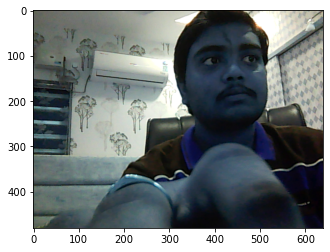

In [7]:
#Taking picture from webcam and detecting emotion
model.load_weights('model.h5')
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
cap=cv2.VideoCapture(0)
ret, frame =cap.read()

facecasc = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

for (x, y, w, h) in faces:
    cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)
    maxindex = int(np.argmax(prediction))
    cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    dominantemotion=emotion_dict[maxindex]
#cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
plt.imshow(frame)
cap.release()
cv2.destroyAllWindows()

In [ ]:
#Playing music from detected emotion
class Playe(tk.Frame):
        def __init__(self, dominantemotion , master=None):
                super().__init__(master)
                self.master = master
                self.pack()
                mixer.init()
                self.dominantemotion=dominantemotion
                print(self.dominantemotion)
            
                self.playlist=[]
                self.current = 0
                self.paused = True
                self.played = False


                self.create_frames()
                self.track_widgets()
                self.control_widgets()
                self.tracklist_widgets()
                self.retrieve_songs()

        def create_frames(self):
                self.track = tk.LabelFrame(self, text='Song Track',
                                        font=("times new roman",15,"bold"),
                                        bg="grey",fg="white",bd=5,relief=tk.GROOVE)
                self.track.config(width=410,height=300)
                self.track.grid(row=0, column=0, padx=10)

                self.tracklist = tk.LabelFrame(self, text=f'PlayList - {str(len(self.playlist))}',
                                                        font=("times new roman",15,"bold"),
                                                        bg="grey",fg="white",bd=5,relief=tk.GROOVE)
                self.tracklist.config(width=190,height=400)
                self.tracklist.grid(row=0, column=1, rowspan=3, pady=5)

                self.controls = tk.LabelFrame(self,
                                                        font=("times new roman",15,"bold"),
                                                        bg="white",fg="white",bd=2,relief=tk.GROOVE)
                self.controls.config(width=410,height=80)
                self.controls.grid(row=2, column=0, pady=5, padx=10)

        def track_widgets(self):
                self.canvas = tk.Label(self.track, image=img)
                self.canvas.configure(width=400, height=240)
                self.canvas.grid(row=0,column=0)

                self.songtrack = tk.Label(self.track, font=("times new roman",16,"bold"),
                                                bg="white",fg="dark blue")
                self.songtrack['text'] = 'VFSTR MP3 Player'
                self.songtrack.config(width=30, height=1)
                self.songtrack.grid(row=1,column=0,padx=10)

        def control_widgets(self):

                self.prev = tk.Button(self.controls, image=prev)
                self.prev['command'] = self.prev_song
                self.prev.grid(row=0, column=1)

                self.pause = tk.Button(self.controls, image=pause)
                self.pause['command'] = self.pause_song
                self.pause.grid(row=0, column=2)

                self.next = tk.Button(self.controls, image=next_)
                self.next['command'] = self.next_song
                self.next.grid(row=0, column=3)

                self.volume = tk.DoubleVar(self)
                self.slider = tk.Scale(self.controls, from_ = 0, to = 10, orient = tk.HORIZONTAL)
                self.slider['variable'] = self.volume
                self.slider.set(8)
                mixer.music.set_volume(0.8)
                self.slider['command'] = self.change_volume
                self.slider.grid(row=0, column=4, padx=5)


        def tracklist_widgets(self):
                self.scrollbar = tk.Scrollbar(self.tracklist, orient=tk.VERTICAL)
                self.scrollbar.grid(row=0,column=1, rowspan=5, sticky='ns')

                self.list = tk.Listbox(self.tracklist, selectmode=tk.SINGLE,
                                         yscrollcommand=self.scrollbar.set, selectbackground='sky blue')
                self.enumerate_songs()
                self.list.config(height=22)
                self.list.bind('<Double-1>', self.play_song)

                self.scrollbar.config(command=self.list.yview)
                self.list.grid(row=0, column=0, rowspan=5)

        def retrieve_songs(self):
                self.songlist = []
                if(self.dominantemotion=='angry'):
                        directory = r'C:\Users\USER\Downloads\Code\Angry'
                elif(self.dominantemotion=='Surprised'):
                        directory = r'C:\Users\USER\Downloads\Code\Sad'
                elif(self.dominantemotion=='Happy'):
                        directory = r'C:\Users\USER\Downloads\Code\Happy'
                elif(self.dominantemotion=='Neutral'):
                        directory = r'C:\Users\USER\Downloads\Code\Neutral'
                elif(self.dominantemotion=='fear'):
                        directory = r'C:\Users\USER\Downloads\Code\Fear'

                #filedialog.askdirectory()
                for root_, dirs, files in os.walk(directory):
                        for file in files:
                                if os.path.splitext(file)[1] == '.mp3':
                                        path = (root_ + '/' + file).replace('\\','/')
                                        self.songlist.append(path)
                self.playlist = self.songlist
                random.shuffle(self.playlist)
                self.tracklist['text'] = f'PlayList - {str(len(self.playlist))}'
                self.list.delete(0, tk.END)
                self.enumerate_songs()
                self.play_song()
        def enumerate_songs(self):
                for index, song in enumerate(self.playlist):
                        self.list.insert(index, os.path.basename(song))


        def play_song(self, event=None):
                if event is not None:
                        self.current = self.list.curselection()[0]
                        for i in range(len(self.playlist)):
                                self.list.itemconfigure(i, bg="white")

                print(self.playlist[self.current])
                mixer.music.load(self.playlist[self.current])
                self.songtrack['anchor'] = 'w'
                self.songtrack['text'] = os.path.basename(self.playlist[self.current])

                self.pause['image'] = play
                self.paused = False
                self.played = True
                self.list.activate(self.current)
                self.list.itemconfigure(self.current, bg='sky blue')

                mixer.music.play()

        def pause_song(self):
                if not self.paused:
                        self.paused = True
                        mixer.music.pause()
                        self.pause['image'] = pause
                else:
                        if self.played == False:
                                self.play_song()
                        self.paused = False
                        mixer.music.unpause()
                        self.pause['image'] = play

        def prev_song(self):
                if self.current > 0:
                        self.current -= 1
                        self.list.itemconfigure(self.current + 1, bg='white')
                else:
                        self.current = 0
                self.play_song()

        def next_song(self):
                if self.current < len(self.playlist) - 1:
                        self.list.itemconfigure(self.current, bg='white')
                        self.current += 1
                else:
                        self.current = 0
                        self.list.itemconfigure(len(self.playlist) - 1, bg='white')
                self.play_song()



        def change_volume(self, event=None):
                self.v = self.volume.get()
                mixer.music.set_volume(self.v / 10)
                

root = tk.Tk()
root.geometry('600x400')
root.wm_title('VFSTR Music Recommendation System')

img = PhotoImage(master=root,file=r'C:\Users\USER\Downloads\Code\images\music.gif')
next_ = PhotoImage(master=root,file = r'C:\Users\USER\Downloads\Code\images\next.gif')
prev = PhotoImage(master=root,file=r'C:\Users\USER\Downloads\Code\images\previous.gif')
play = PhotoImage(master=root,file=r'C:\Users\USER\Downloads\Code\images\play.gif')
pause = PhotoImage(master=root,file=r'C:\Users\USER\Downloads\Code\images\pause.gif')

app = Playe(dominantemotion, master=root)
app.mainloop() 
